Code for Cybersecurity Datasets

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             225745 non-null  int64  
 1    Flow Duration                225745 non-null  int64  
 2    Total Fwd Packets            225745 non-null  int64  
 3    Total Backward Packets       225745 non-null  int64  
 4   Total Length of Fwd Packets   225745 non-null  int64  
 5    Total Length of Bwd Packets  225745 non-null  int64  
 6    Fwd Packet Length Max        225745 non-null  int64  
 7    Fwd Packet Length Min        225745 non-null  int64  
 8    Fwd Packet Length Mean       225745 non-null  float64
 9    Fwd Packet Length Std        225745 non-null  float64
 10  Bwd Packet Length Max         225745 non-null  int64  
 11   Bwd Packet Length Min        225745 non-null  int64  
 12   Bwd Packet Length Mean       225745 non-nul

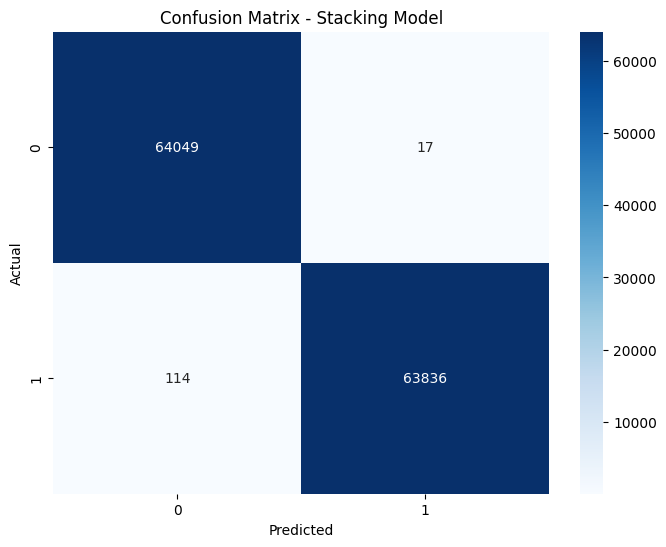

Classification Report:
               precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     64066
        DDoS       1.00      1.00      1.00     63950

    accuracy                           1.00    128016
   macro avg       1.00      1.00      1.00    128016
weighted avg       1.00      1.00      1.00    128016



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

csv_file_path = 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv' 
df = pd.read_csv(csv_file_path)
print(df.info())
print(df.head())
df.drop_duplicates(inplace=True)
df.columns = df.columns.str.strip()

X = df.drop('Label', axis=1) 
y = df['Label'] 

if X.select_dtypes(include=['object']).shape[1] > 0:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    X_encoded = encoder.fit_transform(X)
else:
    X_encoded = X.values 

X_encoded = X_encoded.astype(np.float64)  
X_encoded[np.isinf(X_encoded)] = np.nan

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_encoded = imputer.fit_transform(X_encoded)

scaler = StandardScaler(with_mean=False) 
X_scaled = scaler.fit_transform(X_encoded)

print("Shape of X_scaled:", X_scaled.shape)

unique_classes, class_counts = pd.unique(y), y.value_counts()
print("Unique classes:", unique_classes)
print("Class counts:\n", class_counts)

if len(unique_classes) > 1:
    smote = SMOTE(k_neighbors=1, random_state=42) 
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
else:
    print("Only one unique class found. SMOTE will not be applied.")
    X_resampled, y_resampled = X_scaled, y  

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.5, random_state=42)


base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

meta_model = LogisticRegression()


stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)  
estimators = [('rf', rf_model)]
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)  
)

X_train_subset = X_train[:1000] 
y_train_subset = y_train[:1000]

stacking_model.fit(X_train_subset, y_train_subset)

y_pred = stacking_model.predict(X_test)

print("Improved Stacking Model - Environment Data")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Stacking Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

report = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:\n", classification_report(y_test, y_pred))

metrics = ['precision', 'recall', 'f1-score']
labels = list(report.keys())[:-3] 

precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

x = np.arange(len(labels))  
width = 0.2  

plt.show()

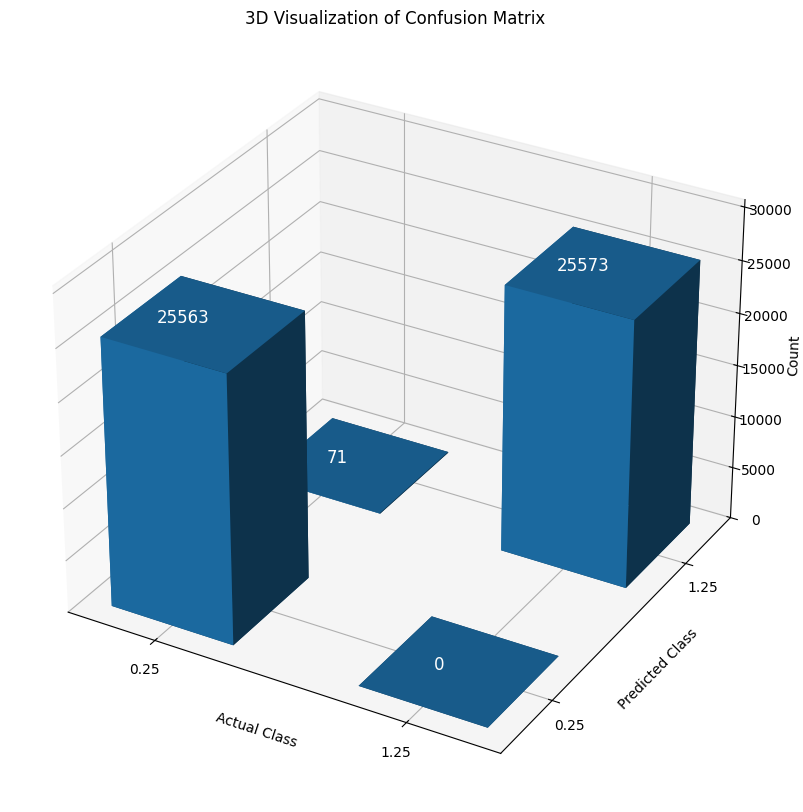

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred = stacking_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

x, y = np.meshgrid(np.arange(cm.shape[0]), np.arange(cm.shape[1]))

x = x.flatten()
y = y.flatten()
z = np.zeros_like(x)

dx = dy = 0.5
dz = cm.flatten()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(x, y, z, dx, dy, dz, shade=True, cmap='viridis')

z_max = max(dz) * 1.2
ax.set_zlim(0, z_max)

ax.set_xticks(np.arange(cm.shape[0]) + dx / 2)
ax.set_yticks(np.arange(cm.shape[1]) + dy / 2)

ax.set_xlabel('Actual Class')
ax.set_ylabel('Predicted Class')
ax.set_zlabel('Count')
ax.set_title('3D Visualization of Confusion Matrix')

for (i, j, count) in zip(x, y, dz):
    ax.text(i + 0.2, j + 0.2, count + 10, f'{int(count)}', color='white', fontsize=12, ha='center', va='bottom')  
   
plt.show()

Code for Patient and Environment Monitoring Datasets

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31758 entries, 0 to 31757
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   frame.time_delta       31758 non-null  float64
 1   frame.time_relative    31758 non-null  float64
 2   frame.len              31758 non-null  int64  
 3   ip.src                 31758 non-null  object 
 4   ip.dst                 31758 non-null  object 
 5   tcp.srcport            31758 non-null  int64  
 6   tcp.dstport            31758 non-null  int64  
 7   tcp.flags              31758 non-null  object 
 8   tcp.time_delta         31758 non-null  float64
 9   tcp.len                31758 non-null  int64  
 10  tcp.ack                31758 non-null  int64  
 11  tcp.connection.fin     31758 non-null  float64
 12  tcp.connection.rst     31758 non-null  float64
 13  tcp.connection.sack    31758 non-null  float64
 14  tcp.connection.syn     31758 non-null  float64
 15  tc

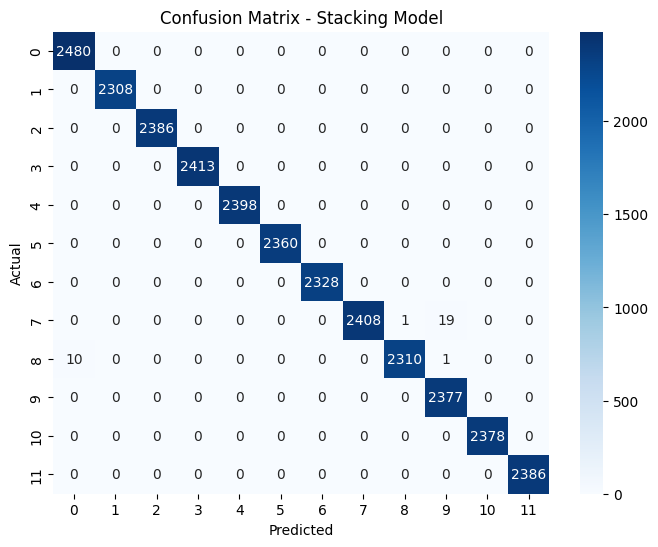

Accuracy of the Stacking Model: 0.9989


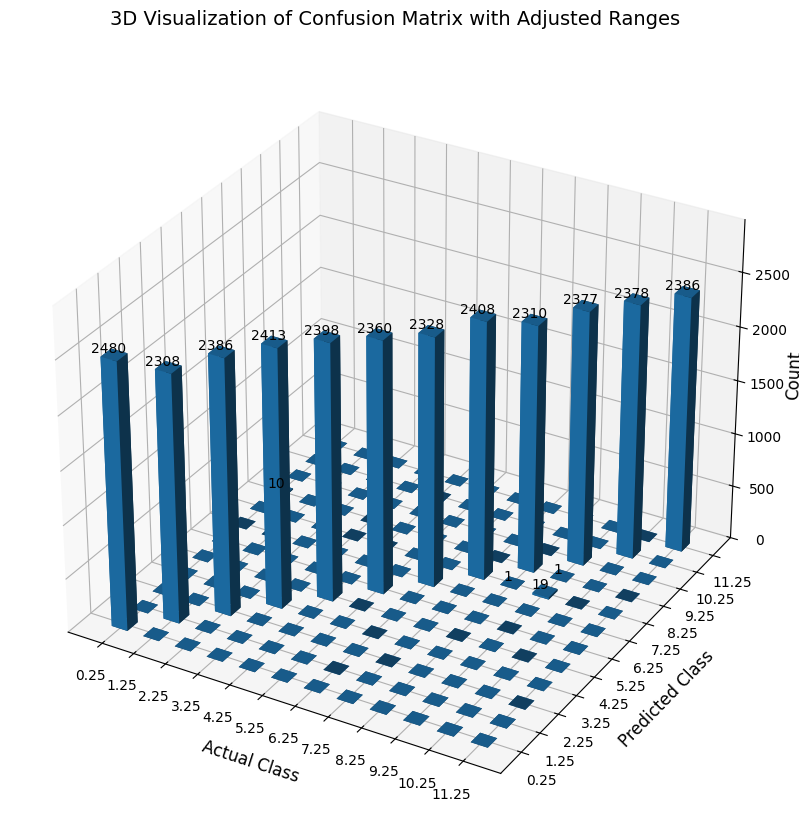

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

dtype_dict = {
    'mqtt.clientid': str,
    'mqtt.conack.flags': str,
    'mqtt.conflags': str,
}

csv_file_path = 'environmentMonitoring.csv' 
df = pd.read_csv(csv_file_path, dtype=dtype_dict)
print(df.info())
print(df.head())

df.drop_duplicates(inplace=True)

X = df.drop('tcp.len', axis=1)  
y = df['tcp.len']  

if X.select_dtypes(include=['object']).shape[1] > 0:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    X_encoded = encoder.fit_transform(X)
else:
    X_encoded = X.values
    
scaler = StandardScaler(with_mean=False)  
X_scaled = scaler.fit_transform(X_encoded)

print("Shape of X_scaled:", X_scaled.shape)

unique_classes, class_counts = pd.unique(y), y.value_counts()
print("Unique classes:", unique_classes)
print("Class counts:\n", class_counts)

if len(unique_classes) > 1:
    smote = SMOTE(k_neighbors=1, random_state=42) 
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
else:
    print("Only one unique class found. SMOTE will not be applied.")
    X_resampled, y_resampled = X_scaled, y 

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

meta_model = LogisticRegression()

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)  

estimators = [('rf', rf_model)]
stacking_model = StackingClassifier(
    estimators=estimators, 
    final_estimator=RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1) 
)

X_train_subset = X_train[:1000] 
y_train_subset = y_train[:1000]

stacking_model.fit(X_train_subset, y_train_subset)

y_pred = stacking_model.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Stacking Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

metrics = ['precision', 'recall', 'f1-score']
labels = list(report.keys())[:-3] 

precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]


x = np.arange(len(labels)) 
width = 0.2 

plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Stacking Model: {accuracy:.4f}")

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred = stacking_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

x, y = np.meshgrid(np.arange(cm.shape[0]), np.arange(cm.shape[1]))

x = x.flatten()
y = y.flatten()
z = np.zeros_like(x)

dx = dy = 0.5 
dz = cm.flatten()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(x, y, z, dx, dy, dz, shade=True, cmap='viridis')

z_max = max(dz) * 1.2 
ax.set_zlim(0, z_max)

ax.set_xticks(np.arange(cm.shape[0]) + dx / 2)
ax.set_yticks(np.arange(cm.shape[1]) + dy / 2)

ax.set_xlabel('Actual Class', fontsize=12, labelpad=10)
ax.set_ylabel('Predicted Class', fontsize=12, labelpad=10)
ax.set_zlabel('Count', fontsize=12)
ax.set_title('3D Visualization of Confusion Matrix with Adjusted Ranges', fontsize=14, pad=20)

ax.tick_params(axis='x', labelsize=10, pad=5)
ax.tick_params(axis='y', labelsize=10, pad=5)
ax.tick_params(axis='z', labelsize=10, pad=5)

for (i, j, count) in zip(x, y, dz):
    if count > 0: 
        ax.text(i + 0.15, j + 0.15, count + 2, f'{int(count)}', color='black', fontsize=10, ha='center', va='bottom')  

plt.show()